In [2]:
import numpy as np
from scipy.io import loadmat
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
hf = h5py.File('/media/maria/DATA1/Documents/ZebraFish/subject_1/TimeSeries.h5', 'r')
#print(hf['absIx'])
neural_dat=np.array(hf['CellResp'])
del hf

regressors=loadmat('/media/maria/DATA1/Documents/ZebraFish/subject_1/data_full.mat')
cell_pos=regressors['data']['CellXYZ'][0][0]
missing_values=regressors['data']['IX_inval_anat'][0][0]
cell_pos=np.delete(cell_pos,missing_values,axis=0)

behavior=regressors['data']['Behavior_full'][0][0]

stim=regressors['data']['stim_full'][0][0].T

In [23]:
from sklearn.decomposition import PCA

pca=PCA(n_components=3)
pcs=pca.fit_transform(behavior.T)
print(pcs.shape)

(2880, 3)


In [24]:
print(neural_dat.shape)
print(stim.shape)

(2880, 83205)
(2880,)


In [38]:
def compute_mean(stim,neural_dat,pcs):
    change_points=[]
    for j in range(0,stim.shape[0]-1):
        if stim[j]!=stim[j+1]:
            change_points.append(j)

    times=[]
    for j in range(0,len(change_points)-1):
        times.append(change_points[j+1]-change_points[j])
        
    stim_=[]
    running=0
    range_arr=[]
    for t in times:
        stim_.append(stim[running+1])
        range_arr.append([running,running+t])
        running+=t
        
    stim_dict={}
    pcs_dict={}
    for trial in range(0,4):
        if trial==0:
            stim_dict[0]=[]
            pcs_dict[0]=[]
        if trial==1:
            stim_dict[1]=[]
            pcs_dict[1]=[]
        if trial==2:
            stim_dict[2]=[]
            pcs_dict[2]=[]
        if trial==3:
            stim_dict[3]=[]
            pcs_dict[3]=[]
    
    for el in range(0,70):
        stim_dict[stim_[el]].append(neural_dat[range_arr[el][0]:range_arr[el][1]][0:30,:])
        pcs_dict[stim_[el]].append(pcs[range_arr[el][0]:range_arr[el][1]][0:30])
        
        
    stim_dict_={}
    
    for trial in range(0,4):
        if trial==0:
            stim_dict_['PhotoTaxis']=np.mean(stim_dict[0],axis=0)
        if trial==1:
            stim_dict_['OptoMotor']=np.mean(stim_dict[1],axis=0)
        if trial==2:
            stim_dict_['Looming']=np.mean(stim_dict[2],axis=0)
        if trial==3:
            stim_dict_['DarkFlashes']=np.mean(stim_dict[3],axis=0)
     
    stim_dct_ns={}
    pcs_dct_means={}
    for trial in range(0,4):
        if trial==0:
            stim_dct_ns[trial]=np.mean(stim_dict[0],axis=0)
            pcs_dct_means[trial]=np.mean(pcs_dict[0],axis=0)
        if trial==1:
            stim_dct_ns[trial]=np.mean(stim_dict[1],axis=0)
            pcs_dct_means[trial]=np.mean(pcs_dict[1],axis=0)
        if trial==2:
            stim_dct_ns[trial]=np.mean(stim_dict[2],axis=0)
            pcs_dct_means[trial]=np.mean(pcs_dict[2],axis=0)
        if trial==3:
            stim_dct_ns[trial]=np.mean(stim_dict[3],axis=0)
            pcs_dct_means[trial]=np.mean(pcs_dict[3],axis=0)
    return stim_dict_, stim_dct_ns,times,stim_, pcs_dct_means

stim_dict,stim_dct_ns,times,stim_,pcsc_dct_means=compute_mean(stim,neural_dat,pcs[:,0])

In [31]:
print(pcs.shape)

(2880, 3)


(30, 83205)


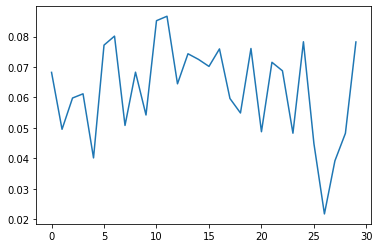

(30, 83205)


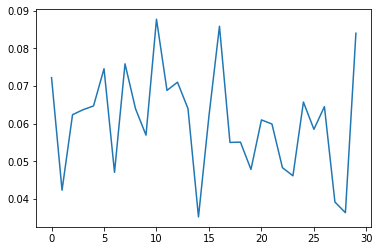

(30, 83205)


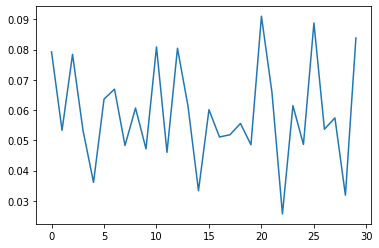

(30, 83205)


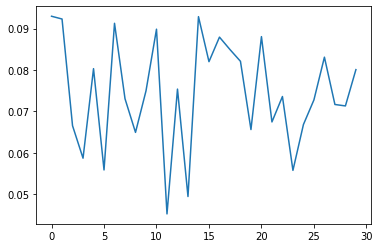

In [18]:
for stm in stim_dict.keys():
    plt.plot(stim_dict[stm][:,0])
    print(stim_dict[stm].shape)
    plt.show()

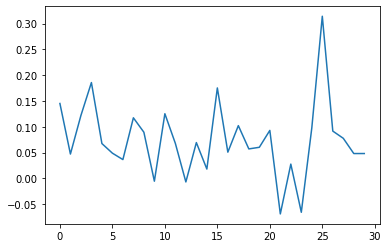

In [19]:
plt.plot(neural_dat[0:30,0])

In [43]:
import time

def compute_beh_corr(pc,times,stim_dict,stim,pcs_dct):
    start=time.time()
    corr_arr=[] 
    running=0
    for t in range(0,4):
        print(running)
        
        corr_lst=[]
        for j in range(0,83205):
            #Add a bit of slack to calculate corrs, motor behaviors happen over a longer time scale
            corr_lst.append(np.corrcoef(pcs_dct[t],stim_dict[t][:,j])[0,1])
        corr_arr.append(corr_lst)
        running+=t
    end=time.time()
    print('Time: ', end-start)
    corr_arr=np.array(corr_arr)
    #np.save('/media/maria/DATA1/Documents/ZebraFish/plots/beh_corr_arrays/beh.npy',corr_arr)
    np.save('beh_arr_trial_av.npy',corr_arr)
    
compute_beh_corr(pcs[:,0],times,stim_dct_ns,stim_,pcsc_dct_means)

0
0
1
3
Time:  30.669649362564087


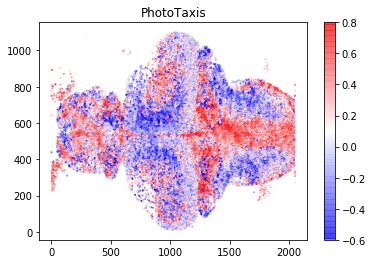

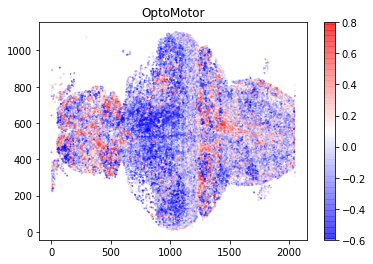

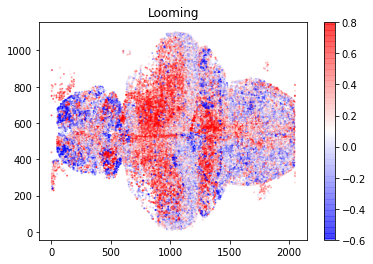

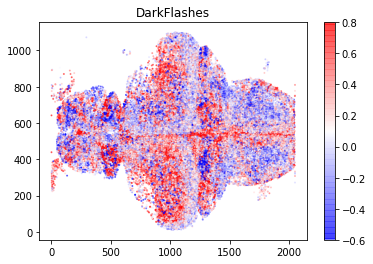

In [50]:
for j in range(0,4):
    if j==0:
        plt.title('PhotoTaxis')
    if j==1:
        plt.title('OptoMotor')
    if j==2:
        plt.title('Looming')
    if j==3:
        plt.title('DarkFlashes')
    plt.scatter(cell_pos[:,0], cell_pos[:,1], s = 1, c = beh_arr[j,:], cmap='bwr', alpha = .5, vmax=0.8, vmin=-0.6)
    plt.colorbar()
    plt.show()

In [44]:
beh_arr=np.load('beh_arr_trial_av.npy')

In [45]:
print(beh_arr.shape)

(4, 83205)


TypeError: title() missing 1 required positional argument: 'label'

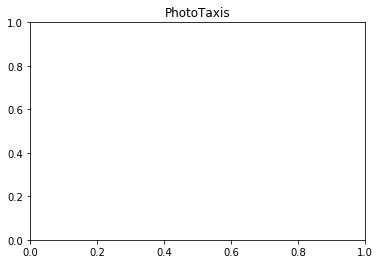

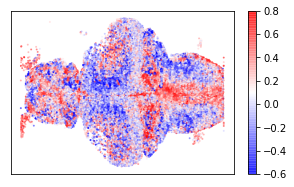

In [56]:
def make_image_files_beh(beh_arr):
    for j in range(0,4):
        fig = plt.figure(figsize=(5,3))
        plt.scatter(cell_pos[:,0], cell_pos[:,1], s = 1, c = beh_arr[j], cmap='bwr', alpha = .5, vmax=0.8, vmin=-0.6)
        plt.colorbar()
        #plt.show()
        plt.xticks([])
        plt.yticks([])
        plt.title()
        if j==0:
            fig.suptitle('PhotoTaxis')
        if j==1:
            fig.suptitle('OptoMotor')
        if j==2:
            fig.title('Looming')
        if j==3:
            fig.title('DarkFlashes')
        plt.savefig('/media/maria/DATA1/Documents/ZebraFish/plots/beh_trial_av/plot_'+str(j)+'.png')
make_image_files_beh(beh_arr)
import imageio
images = []
filenames=['/media/maria/DATA1/Documents/ZebraFish/plots/beh_trial_av/plot_'+str(j)+'.png' for j in range(0,4)]
for filename in filenames:
    images.append(imageio.imread(filename))
print(images)
imageio.mimsave('/media/maria/DATA1/Documents/ZebraFish/plots/beh_trial_av/beh_plots_trial_av.gif', images,fps=0.5)